In [ ]:
import sys
import cv2 # OpenCV library
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage import color, io, feature


# The following is a substitute for cv2.imshow,
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
OpenCV version: 4.8.0
NumPy version:  1.23.5


In [ ]:
def load_image(filename):
  img = np.asarray(Image.open(
    filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(8, 6) # You can adjust the size of the displayed figure
  plt.imshow(img)



(3, 3)


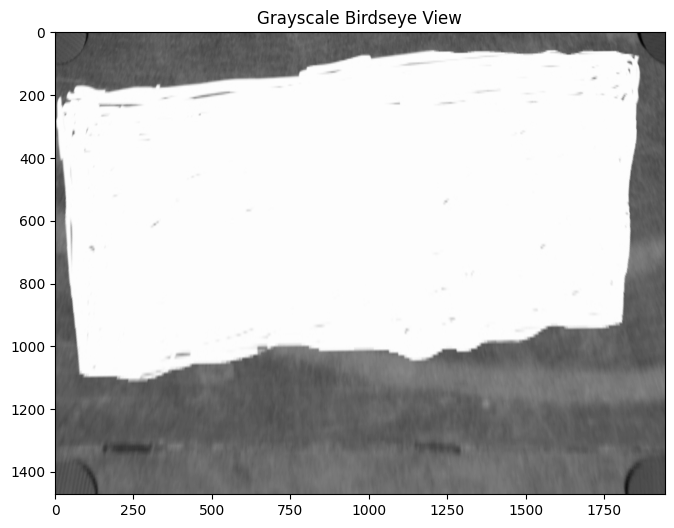

In [ ]:
def compute_3D_homography(src, dst, height):
    N = src.shape[0]
    A = np.zeros((3 * N, 12))

    for i in range(N):
        x, y, z = src[i, 0], src[i, 1], src[i, 2]
        u, v, h = dst[i, 0], dst[i, 1], height[i]

        A[3 * i, :] = [-x, -y, -z, -1, 0, 0, 0, 0, x * u, y * u, z * u, u]
        A[3 * i + 1, :] = [0, 0, 0, 0, -x, -y, -z, -1, x * v, y * v, z * v, v]
        A[3 * i + 2, :] = [0, 0, 0, 0, 0, 0, 0, 0, x, y, z, 1]

    _, _, V = np.linalg.svd(A)
    H_3D = V[-1, :].reshape((3, 4))

    # Normalize the matrix
    H_3D /= H_3D[2, 3]

    return H_3D

def warp_img(src_img, H, dst_img_size):
   dst_img = np.zeros((dst_img_size[0],dst_img_size[1],3))
   H_inv = np.linalg.inv(H)
   for i in range(dst_img_size[0]):
    for j in range(dst_img_size[1]):
      p = np.array([[i],[j],[1]])
      t_p = np.dot(H_inv,p)
      x = int(np.round(t_p[0]/t_p[2]))
      y = int(np.round(t_p[1]/t_p[2]))

      if 0<=x<src_img.shape[0] and 0<=y<src_img.shape[1]:
        dst_img[i,j,:] = src_img[x,y,:]

   return dst_img

def compute_homography(src, dst):
  N = src.shape[0]
  A = np.zeros((2 * N, 9))
  for i in range(N):
      x, y = src[i, 0], src[i, 1]
      u, v = dst[i, 0], dst[i, 1]
      A[2 * i] = [-x, -y, -1, 0, 0, 0, x * u, y * u, u]
      A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * v, y * v, v]

  _, _, V = np.linalg.svd(A)
  H = V[-1, :].reshape((3, 3))


  return H




image1 = load_image("/content/Annotated.jpeg")


import numpy as np

height,width,c = image1.shape


output_size = (width, height)


dst_pts = np.array([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]], dtype=np.float32)


src_pts_3d = np.array([[504, 1341,1.57], [703, 1133,1.57], [1362, 1136,1.57], [1527, 1346,1.57]], dtype=np.float32) #this is can obtained from ros_topic via matlab script
src_pts = np.array([[504, 1341], [703, 1133], [1362, 1136], [1527, 1346]], dtype=np.float32) #this is can obtained from ros_topic via matlab script

h = np.full(len(src_pts),1.57,dtype=float)
M_2D = compute_homography(src_pts,dst_pts)
#M_3D = compute_3D_homography(src_pts_3d,dst_pts,h)
#M = M_3D[:, :3]


print(M_2D.shape)
M_2D_flipped = np.array([[-1, 0, output_size[0]],
                         [0, 1, 0],
                         [0, 0, 1]])

#bev = warp_img(image1,M,output_size)
M_2D = np.dot(M_2D_flipped, M_2D)


birdseye_view = cv2.warpPerspective(image1, M_2D, output_size)
#birdseye_view_test2 = cv2.warpPerspective(image3, M, output_size)

grey_bev = cv2.cvtColor(birdseye_view, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6))
plt.imshow(grey_bev, cmap='gray')
plt.title('Grayscale Birdseye View')
plt.show()




In [ ]:
rw_k = 3/1472
p_k = 1472/3

origin_distance = 3*p_k


no_of_pixels = np.float32

def stopline_check(image):
    global no_of_pixels
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    row_sums = np.sum(grey_image, axis=1)
    rows = np.arange(len(row_sums))

    h,w,c = image.shape

    stop_line_threshold = 1000  # Adjust the threshold as needed

    # Identify rows exceeding the threshold
    exceeding_rows = np.where(row_sums > stop_line_threshold)[0]

    plt.figure(figsize=(12, 6))

    # Subplot 1: Grayscale image
    plt.subplot(1, 2, 1)
    plt.imshow(grey_image, cmap='gray', aspect='auto')
    plt.title('Grayscale Birdseye View')

    # Subplot 2: Plot of intensity sums along rows displayed along columns
    plt.subplot(1, 2, 2)
    plt.plot(row_sums, len(row_sums) - 1 - rows)  # Reverse the y-axis
    plt.ylabel('Row Number')
    plt.xlabel('Sum of Intensity')
    plt.title('Projection')

    # Mark exceeding rows in red
    if len(exceeding_rows) > 0:
        plt.scatter(row_sums[exceeding_rows], len(row_sums) - 1 - rows[exceeding_rows], color='red', label='Exceeding Rows')

        # Print message about stop line and range of exceeding rows
        print("There is a stop line!")
        print("Exceeding rows range: From row {} to row {}".format(exceeding_rows.min(), exceeding_rows.max()))

        # Plot lines on the image
        first_exceeding_row = exceeding_rows.min()
        last_exceeding_row = exceeding_rows.max()

        image_with_lines = image.copy()
        cv2.line(image_with_lines, (0, first_exceeding_row), (image.shape[1] - 1, first_exceeding_row), (0, 255, 0), 2)  # Green line
        cv2.line(image_with_lines, (0, last_exceeding_row), (image.shape[1] - 1, last_exceeding_row), (0, 255, 0), 2)  # Green line

        plt.figure()
        plt.imshow(image_with_lines,cmap='gray')
        plt.title('Image with Stop Lines')

        no_of_pixels = exceeding_rows.max() - exceeding_rows.min()
        # print("no of pixles = "+ str(no_of_pixels))

    plt.legend()
    plt.tight_layout()
    plt.show()





There is a stop line!
Exceeding rows range: From row 68 to row 1055


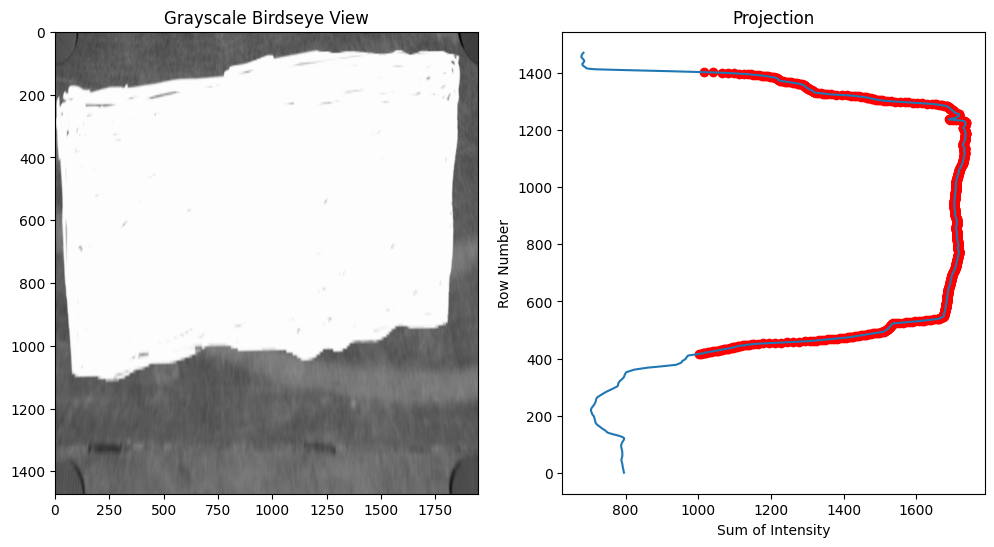

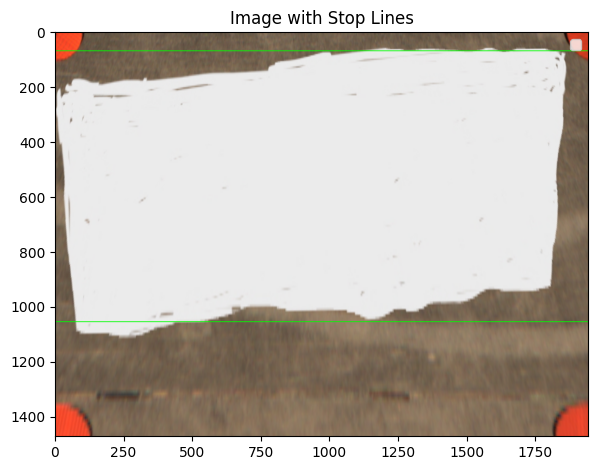

real world distance = 2.011548913043478


In [ ]:
stopline_check(birdseye_view)






In [ ]:
print("real world distance = "+ str(rw_k*no_of_pixels))




real world distance = 2.011548913043478
